# Building a neural network

### Neural networks in code

Building a neural network from scratch in code is no mean feat. Some people make a habit out of it, sometimes going so far as to [live code a neural net library in one hour](https://www.youtube.com/watch?v=o64FV-ez6Gw).

Fortunately, Python [is batteries-included](https://xkcd.com/353/) and has a wonderful community of ML practitioners. There are a number of wonderful, fully-developed and well-supported libraries out there for building and training neural networks.

### Keras 

[Keras](https://keras.io/) is a high-level deep learning library, built to be simple, clear, and easy to use. It's my favourite of the neural network packages. With it, you can build and train a neural network, on a CPU or GPU, very quickly.

The API that Keras provides is its true strength. The heavy lifting -- backpropagation and gradient descent -- are provided by other, lower-level frameworks, such as TensorFlow or Theano.

### Let's dive straight into an example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

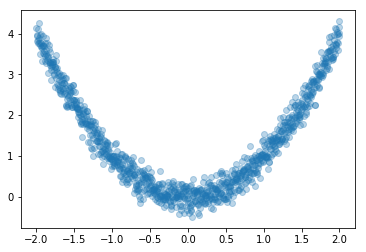

In [2]:
# Generate some data
x = np.linspace(-2, 2, 1000).reshape(-1, 1)
y = x**2 + np.random.randn(*x.shape) * 0.2

# Visualise it in a scatter plot
plt.scatter(x, y, alpha=0.3)

Let's pull a few pieces from Keras.

In [3]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


Next, let's put together a tiny neural net, with only one hidden layer.

In [4]:
np.random.seed(3)

In [5]:
model = Sequential()
model.add(Dense(2, activation="relu", input_dim=1))
model.add(Dense(1, activation="linear"))

We're done defining the net itself. We now need to provide some information for the loss function and gradient descent options.

In [6]:
model.compile(optimizer="sgd", loss="mse")

We're ready to train the net.

In [7]:
history = model.fit(x, y, epochs=30, batch_size=16, verbose=0)

How did we do ?

In [8]:
def plot_network_results(x=x, y=y, model=model, history=history):
    
    plt.figure(figsize=(15, 4))
    
    plt.subplot(121)
    plt.scatter(x, y, alpha=0.3)
    plt.plot(x, model.predict(x), lw=5, c="k")
    plt.legend(["Prediction", "Data"])
    
    plt.subplot(122)
    plt.plot(history.history["loss"], lw=5)
    plt.title("Loss")
    plt.xlabel("Epochs")

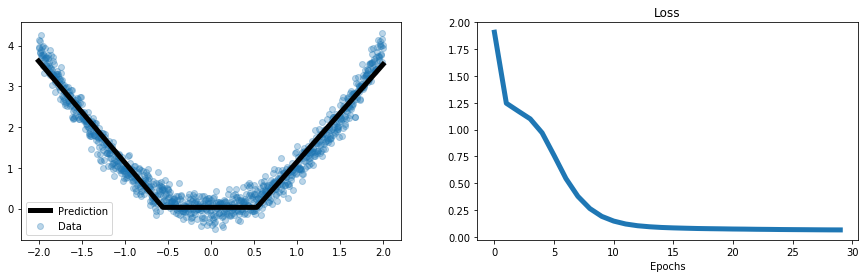

In [9]:
plot_network_results()

A tiny neural network, with one hidden layer containing two units, was able to learn a good approximation of our function.

We say "tiny", but how small is it, really ?

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


### Predicting commute times

Without further ado, let's train a larger network on some more realistic data.

In [12]:
import pandas as pd

# Let's import our data
training_data = pd.read_csv("../data/commute-times-train.csv", index_col=[0])
test_data = pd.read_csv("../data/commute-times-test.csv", index_col=[0])

In [ ]:
from sklearn.preprocessing import StandardScaler

# Neural networks benefit from having their input data scaled
scaler = StandardScaler()
scaler.fit_transform()

In [13]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation

%matplotlib inline

### Raw data

In [14]:
# Read in the raw data
data = pd.read_csv("../data/commute-times-train.csv", index_col=[0])

data.head()

,source_latitude,source_longitude,destination_latitude,destination_longitude,time_of_day_ts,commute_type,commute_time
0,-0.182809,0.361579,0.485623,0.300347,2018-08-13 16:56:00,BUS,25.156297
1,0.160297,0.064330,0.702545,-0.116307,2018-08-13 18:19:00,CAR,12.937429
2,0.762229,0.486693,0.197252,0.790051,2018-08-13 17:36:00,BIKE,29.013729
3,0.187947,0.508487,-0.372924,-0.914006,2018-08-13 07:41:00,CAR,18.215423
4,-0.431013,-0.600620,0.729273,0.215633,2018-08-13 15:56:00,TRAIN,11.196802


### Generate some basic features

This is just to mess around with what I expect Susan might create.

In [15]:
# Create some categorical variables from commute_type
data = pd.concat([data, pd.get_dummies(data["commute_type"])], axis=1).drop(["commute_type"], axis=1)

# Add L2 norm -- it "makes sense" and you might well create this if you 
# didn't know how the data was generated;
# the L1 norm would just be a collinearity mess
data.loc[:, "distance"] = np.sqrt(
    (data["destination_latitude"] - data["source_latitude"])**2 +
    (data["destination_longitude"] - data["source_longitude"])**2
)

data["time_of_day_ts"] = pd.to_datetime(data["time_of_day_ts"])
data["time_of_day"] = data["time_of_day_ts"].dt.hour + data["time_of_day_ts"].dt.minute / 60

data = data.drop(["time_of_day_ts"], axis=1)

data.head()

,source_latitude,source_longitude,destination_latitude,destination_longitude,commute_time,BIKE,BUS,CAR,TRAIN,WALK,distance,time_of_day
0,-0.182809,0.361579,0.485623,0.300347,25.156297,0,1,0,0,0,0.671231,16.933333
1,0.160297,0.064330,0.702545,-0.116307,12.937429,0,0,1,0,0,0.571544,18.316667
2,0.762229,0.486693,0.197252,0.790051,29.013729,1,0,0,0,0,0.641268,17.600000
3,0.187947,0.508487,-0.372924,-0.914006,18.215423,0,0,1,0,0,1.529073,7.683333
4,-0.431013,-0.600620,0.729273,0.215633,11.196802,0,0,0,1,0,1.418637,15.933333


### Create train and test datasets and scale the features for neural net use

In [16]:
np.random.seed(0)

# Create X and y
X = data.drop(["commute_time"], axis=1)
y = data["commute_time"]

# Scale features
X = StandardScaler().fit_transform(X)

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Linear regression

In [17]:
# Train a linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Calculate its RMSE
lr_rmse = np.sqrt(np.mean( (lr.predict(X_test) - y_test)**2 ) )
print("RMSE linear regression : {:.2f}".format(lr_rmse))
print("( R^2 : {:.3f} )".format(lr.score(X_test, y_test)))

RMSE linear regression : 2.24
( R^2 : 0.926 )


### Neural net

RMSE neural network : 1.35


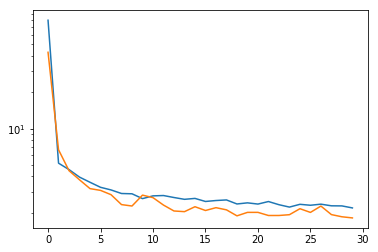

In [19]:
# Simple neural net : three hidden layers, Adam optimiser

model = Sequential()

model.add(Dense(512,  input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation("linear"))

model.compile(loss="mse", optimizer="adam")

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=30,
    verbose=0,
    validation_data=(X_test, y_test)
)

# Calculate RMSE
nn_rmse = np.sqrt(model.evaluate(X_test, y_test, verbose=0))
print("RMSE neural network : {:.2f}".format(nn_rmse))

plt.semilogy(history.history["loss"])
plt.semilogy(history.history["val_loss"])

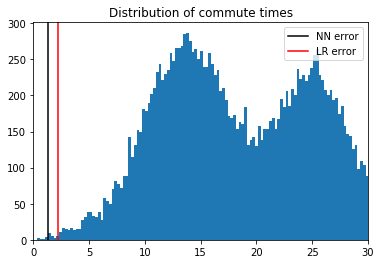

In [20]:
plt.hist(data["commute_time"], bins=200)
plt.axvline(nn_rmse, c="k")
plt.axvline(lr_rmse, c="r")
plt.xlim(0, 30)
plt.title("Distribution of commute times")
plt.legend(["NN error", "LR error"])

### TL; DR :

RMSE of 4.76 for neural nets and 5.59 for linear regression. Compared with the distribution of commute times, it's "realistic", sure, but not great or encouraging. I'm going to keep tweaking the net, and we might have more features, but I think we can make this a little easier -- not much, just a touch.

### Ignore -- grid-searching NNs for posterity

In [30]:
layers = [1, 2, 3, 4, 5, 6, 7]
layer_sizes = [64, 128, 256, 512]
reg_type = ["bn", "do", None]

np.random.seed(0)

def score_nn(layers, layer_size, reg):
    
    np.random.seed(0)
    
    model = Sequential()
    
    model.add(Dense(layer_size, activation="relu", input_dim=X_train.shape[1]))
    if reg is not None:
        if reg == "bn":
            model.add(BatchNormalization())
        elif reg == "do": 
            model.add(Dropout(0.2))
    
    for _ in range(layers-1):
        model.add(Dense(layer_size, activation="relu"))
        if reg is not None:
            if reg == "bn":
                model.add(BatchNormalization())
            elif reg == "do": 
                model.add(Dropout(0.2))
                
    model.add(Dense(1, activation="linear"))
    
    np.random.seed(0)
    model.compile(loss="mse", optimizer="adam")
    np.random.seed(0)

    history = model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=30,
        verbose=0,
        validation_data=(X_test, y_test)
    )

    # Calculate RMSE
    nn_rmse = np.sqrt(model.evaluate(X_test, y_test, verbose=0))

    return nn_rmse

In [ ]:
from tqdm import tqdm

results_bn = np.zeros((len(layers), len(layer_sizes)))
results_do = np.zeros((len(layers), len(layer_sizes)))
results_none = np.zeros((len(layers), len(layer_sizes)))

for i, layer in enumerate(tqdm(layers, desc="BN")):
    for j, layer_size in enumerate(layer_sizes):
        results_bn[i, j] = score_nn(layer, layer_size, "bn")
        
for i, layer in enumerate(tqdm(layers, desc="DO")):
    for j, layer_size in enumerate(layer_sizes):
        results_bn[i, j] = score_nn(layer, layer_size, "do")
        
for i, layer in enumerate(tqdm(layers, desc="None")):
    for j, layer_size in enumerate(layer_sizes):
        results_bn[i, j] = score_nn(layer, layer_size, None)

DO:  43%|████▎     | 3/7 [05:18<07:02, 105.68s/it]

In [33]:
results_bn

5.091942824612819